In [21]:
import os
import tensorflow as tf
# tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[1:],'GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  
with tf.device('/device:GPU:1'):
    print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [22]:
with tf.device('/device:GPU:1'):
    # standard libraries
    import os 
    import math
    import numpy as np 
    import matplotlib.pyplot as plt
    import seaborn as sns
    import glob
    import random
    import cv2
    import gc
    from PIL import Image
    import requests
    from io import BytesIO

    # tensorflow/keras libraries

    from tensorflow.keras import layers
    from tensorflow.keras.preprocessing import image_dataset_from_directory 
    import tensorflow_hub as hub
    from tqdm.keras import TqdmCallback
    from tensorflow.python.keras.backend import set_session as ss

    # config = tf.compat.v1.ConfigProto(device_count = {'GPU': 2})
    # sess = tf.compat.v1.Session(config=config)


    config = tf.compat.v1.ConfigProto(device_count = {'GPU': 2})
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.InteractiveSession(config=config)

    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

    # config = tf.compat.v1.ConfigProto()
    # config.gpu_options.per_process_gpu_memory_fraction = 0.9  # 0.6 sometimes works better for folks
    # tf.keras.backend.tensorflow_backend.set_session(tf.Session(config=config))


2023-04-09 18:42:20.224049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2023-04-09 18:42:20.224546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:86:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2023-04-09 18:42:20.225994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2023-04-09 18:42:20.226106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-04-09 18:42:20.226126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 1 
2023-04-09 18:42:20.226141: I tensorflow/core/common_runtime/gpu/gpu_devic

# Load & View Images

In [23]:
with tf.device('/device:GPU:1'):
    # load images
    IMG_SIZE=160
    BATCH_SIZE=4
    FILE_PATH = '/home/s200010053/Cotton/Cotton_Dataset_New/Cotton_Train'
    CLASSES = os.listdir(FILE_PATH)

    # read from directory
    image_data = image_dataset_from_directory(
        FILE_PATH,
        label_mode='int',
        image_size=(IMG_SIZE,IMG_SIZE),
        batch_size=BATCH_SIZE,
        interpolation='nearest',
        labels='inferred',
        shuffle=True,
        class_names = CLASSES)


Found 5545 files belonging to 8 classes.


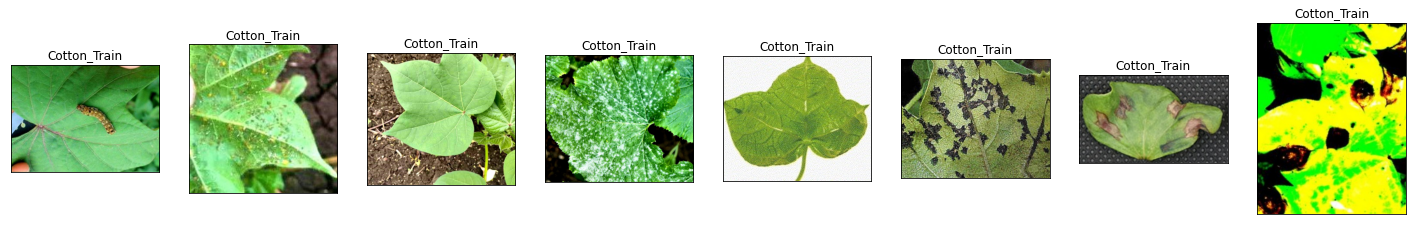

In [24]:
with tf.device('/device:GPU:1'):
# generating a list with 1 random image from each class 
    random_images = []
    for i in enumerate(CLASSES):
        random_images.append(random.choice(glob.glob(os.path.join(FILE_PATH,CLASSES[i[0]]+'/*'))))
        
    # showing each image in seperate column
    n_cols = len(CLASSES)

# plot the images
plt.figure(figsize=(25, 10))
for c,r in zip(range(n_cols),random_images):
    ax = plt.subplot(1, n_cols, c + 1)
    ax.title.set_text(r.split('/')[5])
    image = cv2.imread(r)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.show()

# Data Preprocessing

In [25]:
#data pipeline 
#def convert_to_float(image,label):
#    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
#    return image,label
with tf.device('/device:GPU:1'):
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    # configure training dataset
    '''due to very few images per class, we will be using the entire image data for training'''
    # ds_train = image_data.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
    ds_train = image_data.prefetch(buffer_size=AUTOTUNE)

In [26]:
# data augmentation
'''
Since the dataset is small, as a good practice we'll introduce sample diversity by applying random transformations to the training images.
Here we're applying horizontal flip , rotation, contrast & zoom.
'''
with tf.device('/device:GPU:1'):
  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')
    ,tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ,tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
    ,tf.keras.layers.experimental.preprocessing.RandomZoom(0.5,0.2)
  ])

In [27]:
# rescale pixel values
'''the base model (MobileNetV2) expects pixel values in [-1,1]'''
with tf.device('/device:GPU:1'):
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

In [28]:
# create base model - MobileNet V2
with tf.device('/device:GPU:1'):
    IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,weights='imagenet')

In [29]:
# model's feature extractor shape conversion
with tf.device('/device:GPU:1'):
    image_batch, label_batch = next(iter(ds_train))
    feature_batch = base_model(image_batch)
    print(f"{IMG_SHAPE} converted to {feature_batch.shape}")

2023-04-09 18:42:22.816922: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-09 18:42:22.835798: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2600000000 Hz
2023-04-09 18:42:22.961199: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-09 18:42:23.767221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2023-04-09 18:42:25.114121: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


(160, 160, 3) converted to (4, 5, 5, 1280)


2023-04-09 18:42:25.933394: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


# Build Model

In [30]:
# feature extraction
'''it is imperative to freeze the layers from being updated during training'''
with tf.device('/device:GPU:1'):
    base_model.trainable = False

In [31]:
# classification head
with tf.device('/device:GPU:1'):
    global_average_layer = layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    print(f"Feature Batch Shape: {feature_batch_average.shape} ")

    # prediction layer
    prediction_layer =  layers.Dense(len(CLASSES),activation='softmax')
    prediction_batch = prediction_layer(feature_batch_average)
    print(f"Prediction Batch Shape: {prediction_batch.shape}")

Feature Batch Shape: (4, 1280) 
Prediction Batch Shape: (4, 8)


In [32]:
# build model
with tf.device('/device:GPU:1'):
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

In [33]:
# model summary
with tf.device('/device:GPU:1'):
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

# Compile & Train Model

In [34]:
# compile the model
with tf.device('/device:GPU:1'):
    base_learning_rate = 0.0001
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [35]:
# training the model
with tf.device('/device:GPU:1'):
    epochs = 15
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3,verbose=0)
    hist = model.fit(ds_train
            , epochs = epochs
            , batch_size=BATCH_SIZE
            ,shuffle=True
            ,verbose=0
            ,callbacks=[TqdmCallback(verbose=0),earlyStopping])

0epoch [00:00, ?epoch/s]

2023-04-09 18:42:35.026385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-09 18:42:39.216167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-09 18:42:42.894583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-09 18:42:42.894636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-04-09 18:42:47.256119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-09 18:42:47.256171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-04-09 18:42:53.763291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-09 18:42:58.064434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h

In [36]:
with tf.device('/device:GPU:1'):
    acc = '{:.2%}'.format(hist.history['accuracy'][-1])
    print(f"Our model has achieved an accuracy of  {acc} in {len(hist.epoch)} epoch(s)")

Our model has achieved an accuracy of  88.69% in 15 epoch(s)


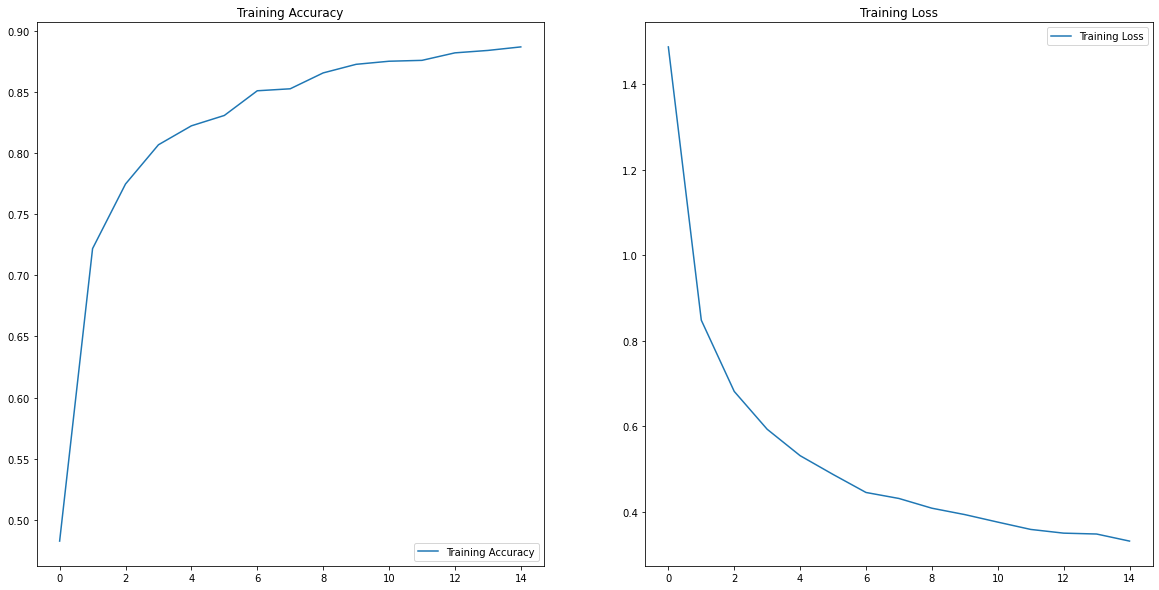

In [37]:
with tf.device('/device:GPU:1'):
# plotting training accuracy & loss.
    acc = hist.history['accuracy']
    loss = hist.history['loss']
    epochs_range = range(len(hist.epoch))

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.title('Training Loss')
    plt.show()

In [38]:
# saving the model
with tf.device('/device:GPU:1'):
    model.save_weights("CottonV4.h5")

# Fine-Tuning Model

In [39]:
# fine tuning
'''
trying to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, 
the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images
'''
with tf.device('/device:GPU:1'):
    base_model.trainable = True

    # check number of layers in base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # fine tuning top layers
    fine_tune_at = 100

    # freeze layers before the *fine_tune_at* layer
    for l in base_model.layers[:fine_tune_at]:
        l.trainable = False

Number of layers in the base model:  154


In [40]:
# re-compile the model
'''using a lower learning rate to avoid overfitting'''
with tf.device('/device:GPU:1'):
    model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# model summary
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [41]:
# re-training the model
with tf.device('/device:GPU:1'):
    hist_finetune = model.fit(ds_train
          , epochs = epochs
          , batch_size=BATCH_SIZE
          ,shuffle=True
          ,verbose=0
          ,callbacks=[TqdmCallback(verbose=0),earlyStopping])

0epoch [00:00, ?epoch/s]

2023-04-09 18:47:28.849138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-09 18:47:36.337167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-09 18:47:42.975375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-09 18:47:42.975469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-04-09 18:47:50.799857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-04-09 18:47:50.799979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-04-09 18:48:01.919604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-09 18:48:09.529955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h

In [42]:
with tf.device('/device:GPU:1'):
    acc_finetuned = '{:.2%}'.format(hist_finetune.history['accuracy'][-1])
    print(f"After finetuning our model has achieved an accuracy of  {acc_finetuned} in {len(hist_finetune.epoch)} epoch(s)")

After finetuning our model has achieved an accuracy of  97.94% in 15 epoch(s)


In [76]:
# saving the model
with tf.device('/device:GPU:1'):
    model.save("Cotton_finetunedV4.h5")
    # model.save("Cotton")

/home/s200010053/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Making Prediction

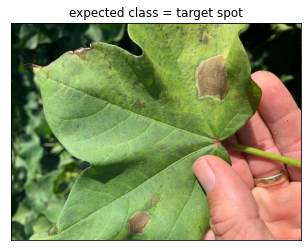

In [77]:

'''
get an image for predictions
since there are no test/validation images, I'll be loading a completely unseen image from Google and see what the model has to predict.
the image is of class = target spot (expected)
'''
with tf.device('/device:GPU:1'):
    img_url = 'https://site.extension.uga.edu/bullochag/files/2022/08/image-1.png'   
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))

    # saving the image to output as jpg
    img_data = requests.get(img_url).content
    with open('unseenImage.jpg', 'wb') as handler:
        handler.write(img_data)

    # plot the image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title('expected class = target spot')
    plt.show()

In [78]:
# pre-processing the unseen image
with tf.device('/device:GPU:1'):
    image_path = 'Cotton_Dataset_New/Cotton_Train/Cotton leaf curl/curl00.jpg'
    unseen_img = tf.keras.preprocessing.image.load_img(image_path,target_size=(IMG_SIZE, IMG_SIZE))
    input_arr = tf.keras.preprocessing.image.img_to_array(unseen_img)
    # convert single image to a batch
    input_arr = np.array([input_arr])  
    input_arr = input_arr.astype('float32') / 255. 

In [82]:
# making prediction
# with tf.device('/device:GPU:1'):

def Predict_Disease(argument):
    classes = {
        0: "Aphids",
        1: "Army Worm",
        2: "Bacterial blight",
        3: "Cotton leaf curl",
        4: "Fussarium wilt",
        5: "Grey mildew",
        6: "Healthy",
        7: "Target Spot"
}
    return classes.get(argument, "nothing")



model = tf.keras.models.load_model('Cotton_finetunedV4.h5')
pred = model.predict(input_arr)
# predicting class
pred_class = np.argmax(pred, axis=1)
pred_class = int(pred_class)
pred_class = Predict_Disease(pred_class)
print(pred_class)

Cotton leaf curl


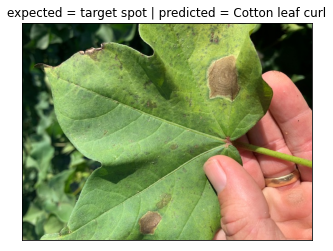

In [80]:
# plot the image
with tf.device('/device:GPU:1'):
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title('expected = target spot | predicted = '+ pred_class_name)
    plt.show()